In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import find_peaks
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive

# ✅ 挂载 Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
start_index = 700
end_index = 731
range_tag = f"{start_index}-{end_index}"

BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
LOGITS_PATH = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}-hidden.json"
ERROR_INDEX_PATH = f"{BASE_PATH}/output/error_index/{range_tag}_hidden_index.json"
PDF_OUTPUT_PATH = f"{BASE_PATH}/output/visualization/hidden_semantic_turning_{range_tag}.pdf"

# ✅ 加载数据
with open(LOGITS_PATH, "r") as f:
    logits_data = json.load(f)
with open(ERROR_INDEX_PATH, "r") as f:
    error_index_data = json.load(f)

os.makedirs(os.path.dirname(PDF_OUTPUT_PATH), exist_ok=True)

# ✅ 计算相邻 token 的 cosine similarity
def compute_token_similarities(token_level):
    vectors = []
    tokens = []
    for entry in token_level:
        if "hidden_vector" in entry:
            vectors.append(entry["hidden_vector"])
            tokens.append(entry["token"])
    similarities = []
    for i in range(len(vectors) - 1):
        sim = cosine_similarity(
            np.array(vectors[i]).reshape(1, -1),
            np.array(vectors[i+1]).reshape(1, -1)
        )[0][0]
        similarities.append(sim)
    return similarities, tokens[:-1]

# ✅ 语义边界
def find_semantic_boundaries(similarities, distance=2, prominence=0.05, height=None):
    inverted = -np.array(similarities)
    peaks, _ = find_peaks(inverted, distance=distance, prominence=prominence, height=height)
    return peaks.tolist()

# ✅ 修改后的绘图函数，支持错误 index 可视化
def plot_similarity(ax, similarities, tokens, boundaries, title, error_start=None, error_end=None):
    ax.plot(range(len(similarities)), similarities, marker='o', label="Cosine Similarity", alpha=0.8)
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90, fontsize=6)
    ax.set_ylim(0.0, 1.05)
    ax.set_ylabel("Cosine Similarity")
    ax.set_title(title, fontsize=10)
    ax.grid(True)

    # ✅ semantic boundaries（绿色虚线）
    for b in boundaries:
        ax.axvline(x=b, color="green", linestyle="--", alpha=0.5, label="Semantic Boundary" if b == boundaries[0] else None)

    # ✅ error span（红色实线）
    if error_start is not None:
        ax.axvline(x=error_start, color="red", linestyle="-", alpha=0.7, label="Error Start")
    if error_end is not None:
        ax.axvline(x=error_end, color="red", linestyle="-", alpha=0.7, label="Error End")

    ax.legend()


# ✅ 主循环
with PdfPages(PDF_OUTPUT_PATH) as pdf:
    for qid, sample in logits_data.items():
        for sid in ["sampling0", "sampling1", "sampling2"]:
            if sid not in sample or "token_probs" not in sample[sid]:
                continue

            token_level = sample[sid]["token_probs"]

            try:
                similarities, tokens = compute_token_similarities(token_level)
                if len(similarities) < 2:
                    continue

                boundaries = find_semantic_boundaries(
                    similarities,
                    distance=5,
                    prominence=0.15
                )

                # ✅ 获取 error index
                error_info = error_index_data.get(qid, {}).get(sid, {})
                error_start = error_info.get("first_error_token_index", None)
                error_end = error_info.get("last_error_token_index", None)

                # ✅ 绘图
                fig, ax = plt.subplots(figsize=(16, 4))
                title = f"{qid} - {sid}"
                plot_similarity(ax, similarities, tokens, boundaries, title, error_start, error_end)

                pdf.savefig(fig)
                plt.close(fig)
            except Exception as e:
                print(f"[ERROR] Skipped {qid}-{sid}: {e}")
                continue

print(f"✅ All similarity plots saved to: {PDF_OUTPUT_PATH}")

✅ All similarity plots saved to: /content/drive/MyDrive/Cluster-proj/output/visualization/hidden_semantic_turning_700-731.pdf


In [4]:
error_index_data.keys()

dict_keys(['q_700', 'q_701', 'q_703', 'q_705', 'q_707', 'q_708', 'q_709', 'q_710', 'q_711', 'q_712', 'q_714', 'q_715', 'q_716', 'q_717', 'q_718', 'q_720', 'q_721', 'q_723', 'q_724', 'q_726', 'q_727', 'q_730'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 收集到 36 条 error 曲线
✅ PCA 完成，前两主成分解释率: [0.53137342 0.16633463]


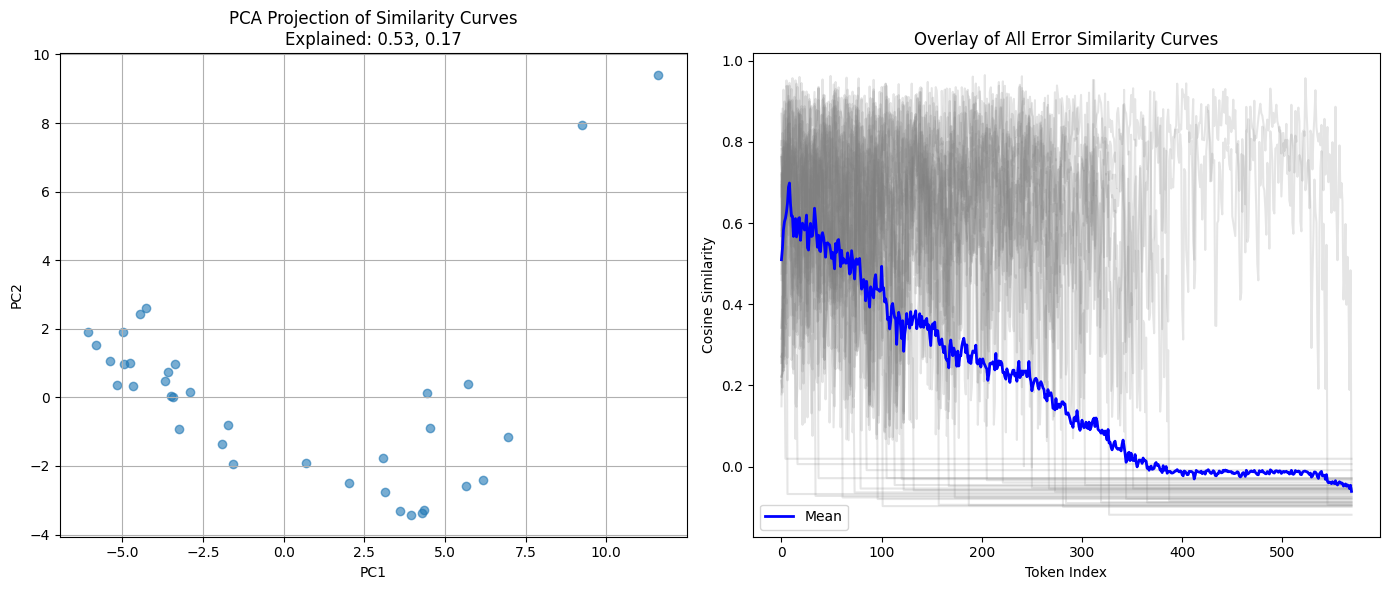

📊 PCA图已保存: /content/drive/MyDrive/Cluster-proj/output/pca/pca_curve_700-731.png


In [5]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from google.colab import drive

# ✅ 挂载 Google Drive
drive.mount('/content/drive')

# ✅ 参数配置
start_index = 700
end_index = 731
range_tag = f"{start_index}-{end_index}"

BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
LOGITS_PATH = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}-hidden.json"
ERROR_INDEX_PATH = f"{BASE_PATH}/output/error_index/{range_tag}_hidden_index.json"
os.makedirs(f"{BASE_PATH}/output/pca", exist_ok=True)
PCA_SAVE_PATH = f"{BASE_PATH}/output/pca/pca_curve_{range_tag}.png"

# ✅ 加载数据
with open(LOGITS_PATH, "r") as f:
    logits_data = json.load(f)
with open(ERROR_INDEX_PATH, "r") as f:
    error_index_data = json.load(f)

# ✅ 计算 cosine similarity
def compute_token_similarities(token_level):
    vectors = []
    for entry in token_level:
        if "hidden_vector" in entry:
            vectors.append(entry["hidden_vector"])
    similarities = []
    for i in range(len(vectors) - 1):
        sim = cosine_similarity(
            np.array(vectors[i]).reshape(1, -1),
            np.array(vectors[i + 1]).reshape(1, -1)
        )[0][0]
        similarities.append(sim)
    return similarities

# ✅ 收集所有出错样本的 similarity 曲线
similarity_list = []

for qid, sample in logits_data.items():
    for sid in ["sampling0", "sampling1", "sampling2"]:
        if sid not in sample or "token_probs" not in sample[sid]:
            continue
        if qid not in error_index_data or sid not in error_index_data[qid]:
            continue  # 仅处理有 error 的样本

        try:
            token_level = sample[sid]["token_probs"]
            similarities = compute_token_similarities(token_level)
            if len(similarities) < 5:
                continue
            similarity_list.append(similarities)
        except Exception as e:
            print(f"[ERROR] {qid}-{sid} failed: {e}")
            continue

print(f"✅ 收集到 {len(similarity_list)} 条 error 曲线")

# ✅ Padding 到相同长度（例如 max_len=128）
max_len = max(len(s) for s in similarity_list)
padded_data = np.array([
    s + [s[-1]] * (max_len - len(s)) for s in similarity_list  # pad with last value
])

# ✅ 主成分分析 PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(padded_data)
explained = pca.explained_variance_ratio_
print(f"✅ PCA 完成，前两主成分解释率: {explained}")

# ✅ 可视化 PCA 投影 + 平均 similarity 曲线
plt.figure(figsize=(14, 6))

# subplot 1: PCA embedding
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA Projection of Similarity Curves\nExplained: {explained[0]:.2f}, {explained[1]:.2f}")
plt.grid(True)

# subplot 2: All curves overlay
plt.subplot(1, 2, 2)
for sim in padded_data:
    plt.plot(sim, alpha=0.2, color='gray')
plt.plot(np.mean(padded_data, axis=0), color='blue', linewidth=2, label="Mean")
plt.xlabel("Token Index")
plt.ylabel("Cosine Similarity")
plt.title("Overlay of All Error Similarity Curves")
plt.legend()

plt.tight_layout()
plt.savefig(PCA_SAVE_PATH)
plt.show()

print(f"📊 PCA图已保存: {PCA_SAVE_PATH}")


✅ 收集到 33 段 error span similarity
✅ PCA 完成，前两主成分解释率: [0.74308685 0.09177795]


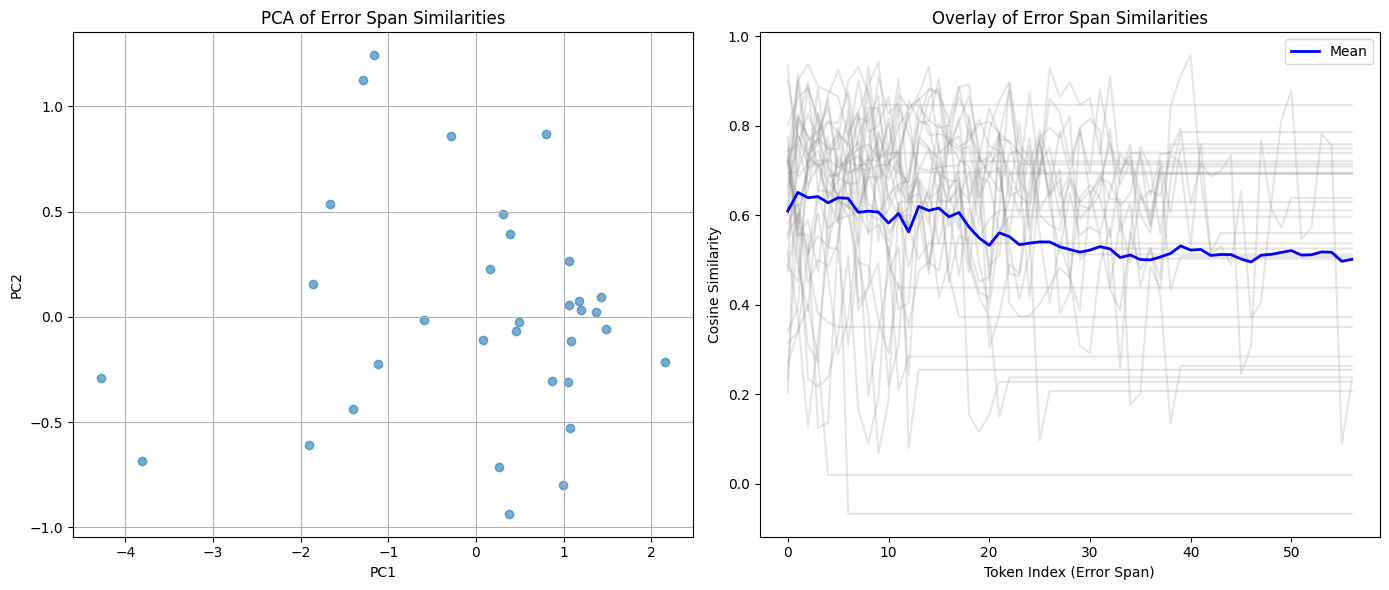

In [6]:
# ✅ 收集所有出错样本的 error span similarity 子序列
error_spans = []

for qid, sample in logits_data.items():
    for sid in ["sampling0", "sampling1", "sampling2"]:
        if sid not in sample or "token_probs" not in sample[sid]:
            continue
        error_info = error_index_data.get(qid, {}).get(sid, {})
        if "first_error_token_index" not in error_info or "last_error_token_index" not in error_info:
            continue  # 跳过没有 error span 的

        try:
            token_level = sample[sid]["token_probs"]
            similarities = compute_token_similarities(token_level)

            # ✅ 提取 error span 范围内的 similarity 子序列
            start = error_info["first_error_token_index"]
            end = error_info["last_error_token_index"]

            if start >= len(similarities) or end >= len(similarities) or start > end:
                continue  # 无效 span

            error_segment = similarities[start:end+1]
            if len(error_segment) < 2:
                continue  # 太短不分析

            error_spans.append(error_segment)
        except Exception as e:
            print(f"[ERROR] {qid}-{sid} skipped: {e}")
            continue

print(f"✅ 收集到 {len(error_spans)} 段 error span similarity")

# ✅ padding 处理
max_len = max(len(seg) for seg in error_spans)
padded_spans = np.array([
    seg + [seg[-1]] * (max_len - len(seg)) for seg in error_spans
])

# ✅ PCA 分析
pca = PCA(n_components=2)
pca_result = pca.fit_transform(padded_spans)
explained = pca.explained_variance_ratio_
print(f"✅ PCA 完成，前两主成分解释率: {explained}")

# ✅ 可视化
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Error Span Similarities")
plt.grid(True)

plt.subplot(1, 2, 2)
for seg in padded_spans:
    plt.plot(seg, alpha=0.2, color="gray")
plt.plot(np.mean(padded_spans, axis=0), color='blue', linewidth=2, label="Mean")
plt.xlabel("Token Index (Error Span)")
plt.ylabel("Cosine Similarity")
plt.title("Overlay of Error Span Similarities")
plt.legend()

plt.tight_layout()
plt.savefig(f"{BASE_PATH}/output/pca/error_span_pca_{range_tag}.png")
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 收集到 846 个 error token 的 hidden vector，维度为 4096
✅ PCA 完成，解释率: [0.10389891 0.04007192]


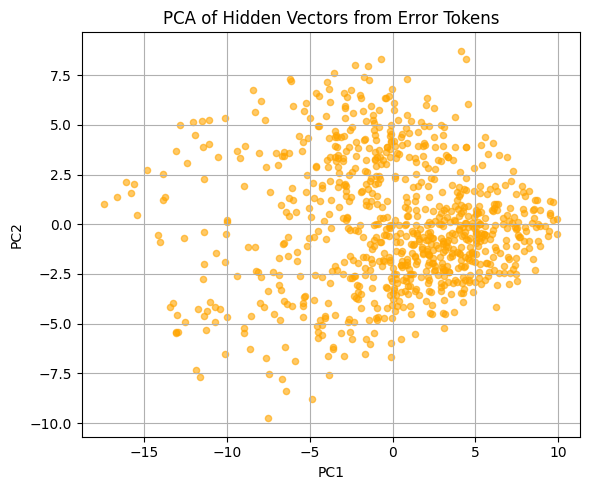

📊 图已保存到: /content/drive/MyDrive/Cluster-proj/output/pca/error_token_hidden_pca_700-731.png


In [7]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from google.colab import drive

# ✅ 挂载 Google Drive
drive.mount('/content/drive')

# ✅ 参数配置
start_index = 700
end_index = 731
range_tag = f"{start_index}-{end_index}"

BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
LOGITS_PATH = f"{BASE_PATH}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}-hidden.json"
ERROR_INDEX_PATH = f"{BASE_PATH}/output/error_index/{range_tag}_hidden_index.json"
PCA_SAVE_PATH = f"{BASE_PATH}/output/pca/error_token_hidden_pca_{range_tag}.png"
os.makedirs(os.path.dirname(PCA_SAVE_PATH), exist_ok=True)

# ✅ 加载数据
with open(LOGITS_PATH, "r") as f:
    logits_data = json.load(f)
with open(ERROR_INDEX_PATH, "r") as f:
    error_index_data = json.load(f)

# ✅ 收集所有 error token 的 hidden vector
error_vectors = []

for qid, sample in logits_data.items():
    for sid in ["sampling0", "sampling1", "sampling2"]:
        if sid not in sample or "token_probs" not in sample[sid]:
            continue
        error_info = error_index_data.get(qid, {}).get(sid, {})
        if "first_error_token_index" not in error_info or "last_error_token_index" not in error_info:
            continue

        try:
            token_level = sample[sid]["token_probs"]
            start = error_info["first_error_token_index"]
            end = error_info["last_error_token_index"]
            for i in range(start, end + 1):
                if i < len(token_level) and "hidden_vector" in token_level[i]:
                    error_vectors.append(token_level[i]["hidden_vector"])
        except Exception as e:
            print(f"[ERROR] {qid}-{sid} skipped: {e}")

# ✅ PCA 降维
error_matrix = np.array(error_vectors)
print(f"✅ 收集到 {error_matrix.shape[0]} 个 error token 的 hidden vector，维度为 {error_matrix.shape[1]}")

pca = PCA(n_components=2)
reduced = pca.fit_transform(error_matrix)
explained = pca.explained_variance_ratio_
print(f"✅ PCA 完成，解释率: {explained}")

# ✅ 可视化结果
plt.figure(figsize=(6, 5))
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6, s=20, color='orange')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Hidden Vectors from Error Tokens")
plt.grid(True)
plt.tight_layout()
plt.savefig(PCA_SAVE_PATH)
plt.show()

print(f"📊 图已保存到: {PCA_SAVE_PATH}")


✅ error tokens: 843
✅ non-error tokens: 15444
✅ PCA 完成，解释率: [0.11395099 0.04218284]


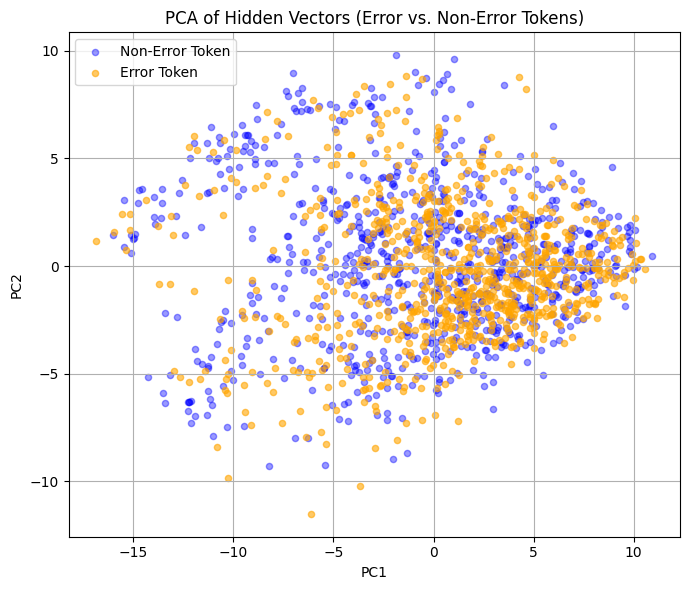

📊 图已保存到: /content/drive/MyDrive/Cluster-proj/output/pca/error_nonerror_hidden_pca_700-731.png


In [10]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from google.colab import drive
import random
PCA_SAVE_PATH = f"{BASE_PATH}/output/pca/error_nonerror_hidden_pca_{range_tag}.png"
os.makedirs(os.path.dirname(PCA_SAVE_PATH), exist_ok=True)

error_vectors = []
non_error_vectors = []

for qid, sample in logits_data.items():
    for sid in ["sampling0", "sampling1", "sampling2"]:
        if sid not in sample or "token_probs" not in sample[sid]:
            continue
        token_level = sample[sid]["token_probs"]
        error_info = error_index_data.get(qid, {}).get(sid, {})
        start = error_info.get("first_error_token_index", None)
        end = error_info.get("last_error_token_index", None)

        for i, token_info in enumerate(token_level):
            if "hidden_vector" not in token_info:
                continue
            vec = token_info["hidden_vector"]
            if start is not None and end is not None and start <= i <= end:
                error_vectors.append(vec)
            else:
                non_error_vectors.append(vec)

print(f"✅ error tokens: {len(error_vectors)}")
print(f"✅ non-error tokens: {len(non_error_vectors)}")

# ✅ 从 non-error 中随机采样相同数量
random.seed(42)
sampled_non_error_vectors = random.sample(non_error_vectors, len(error_vectors))

# ✅ 拼接并打标签
X = np.array(error_vectors + sampled_non_error_vectors)
y = np.array([1] * len(error_vectors) + [0] * len(sampled_non_error_vectors))  # 1=error, 0=non-error

# ✅ PCA 降维
pca = PCA(n_components=2)
reduced = pca.fit_transform(X)
explained = pca.explained_variance_ratio_
print(f"✅ PCA 完成，解释率: {explained}")

# ✅ 可视化
plt.figure(figsize=(7, 6))
plt.scatter(reduced[y==0, 0], reduced[y==0, 1], c='blue', alpha=0.4, s=20, label="Non-Error Token")
plt.scatter(reduced[y==1, 0], reduced[y==1, 1], c='orange', alpha=0.6, s=20, label="Error Token")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Hidden Vectors (Error vs. Non-Error Tokens)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(PCA_SAVE_PATH)
plt.show()

print(f"📊 图已保存到: {PCA_SAVE_PATH}")